In [1]:
from metrics import Evaluate
from models import VectorSpaceModel
from os.path import exists

import data_loading as d_load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
if (exists('train_data.obj') and 
    exists('test_data.obj') and 
    exists('trials_data.obj')):
    
    #load the objects from pickle
    file_data = open('train_data.obj', 'rb') 
    train = pickle.load(file_data)
    file_data.close()
    
    file_data = open('test_data.obj', 'rb') 
    test = pickle.load(file_data)
    file_data.close()
    
    file_data = open('trials_data.obj', 'rb') 
    trials = pickle.load(file_data)
    file_data.close()

else:
    
    train, test = d_load.load_and_split_queries()
    trials = d_load.load_evaluated_trials()

    #Save the data objects to files
    file_data = open('train_data.obj', 'wb') 
    pickle.dump(train, file_data)
    file_data.close()

    file_data = open('test_data.obj', 'wb') 
    pickle.dump(test, file_data)
    file_data.close()

    file_data = open('trials_data.obj', 'wb') 
    pickle.dump(trials, file_data)
    file_data.close()

In [3]:
vector_model = VectorSpaceModel(trials, tokenize = True)
df_metrics = pd.DataFrame(data=None, columns = ['P@10', 'recall', 'AP', 'NDCG5', 'MRR', 
                                               '11-point-precision', '11-point-recall'])

for query in train:
    search_results = vector_model.get_top_query_results(query.query_content)
    eval = Evaluate(query, search_results)
    
    df_metrics.loc[query.query_id] = [eval.p10, eval.recall, eval.ap, eval.ndcg5,
                                      eval.mrr, eval.precision_11point, eval.recall_11point]

df_metrics.loc['average'] = [df_metrics['P@10'].mean(), df_metrics['recall'].mean(),
                             df_metrics['AP'].mean(), df_metrics['NDCG5'].mean(),
                             df_metrics['MRR'].mean(), 
                             np.array(df_metrics['11-point-precision'].values.tolist()).mean(axis=0),
                             np.array(df_metrics['11-point-recall'].values.tolist()).mean(axis=0)]

print(df_metrics.loc['average'])

if False:
    model_data = open('baseline 1.obj', 'wb')
    pickle.dump(df_metrics, model_data)
    model_data.close()

P@10                                                           0.014894
recall                                                         0.066586
AP                                                             0.003401
NDCG5                                                          0.008383
MRR                                                            0.005035
11-point-precision    [0.27772680761768087, 0.07906431331721377, 0.0...
11-point-recall       [0.0, 0.09999999999999999, 0.19999999999999998...
Name: average, dtype: object


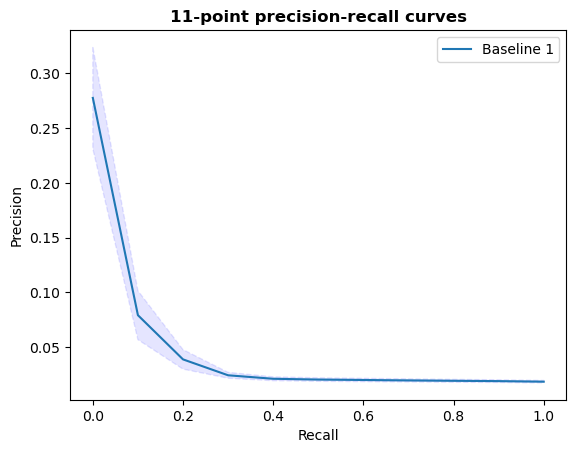

In [4]:
std_recall = np.array(df_metrics['11-point-recall'].values.tolist()).std(axis=0)
se_recall = std_recall/np.sqrt(len(train))

std_precision = np.array(df_metrics['11-point-precision'].values.tolist()).std(axis=0)
se_precision = std_precision/np.sqrt(len(train))
                            
plt.plot(df_metrics.loc['average']['11-point-recall'],
         df_metrics.loc['average']['11-point-precision'])

plt.fill_between(df_metrics.loc['average']['11-point-recall'],
                 df_metrics.loc['average']['11-point-precision'] - se_precision,
                 df_metrics.loc['average']['11-point-precision'] + se_precision,
                 alpha = 0.1, color='b', linestyle = 'dashed', label='_se_')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-point precision-recall curves', fontweight='bold')
plt.legend(['Baseline 1'])

In [5]:
#Drugi model